In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import ast
import numpy as np
from statistics import mean 
from scipy.stats import probplot
import statsmodels.api as stats

### Exploratory Question: How do movie ratings (vote average) relate to box-office performance? #4

#### The R-squared is in line with what is seen in these plots in that there is still a significant amount of variability that hasn't been explained with just Vote Average and Revenue. We have a low r-squared value as it is looking at how much variability in Vote Average vs Revenue is explained by the model. 

In [4]:
# Read the csv file in
movies_2015_2024 = pd.read_csv('../data/movies_2015_2024.csv')

# Calculate the Profit column and add it to the df
movies_2015_2024['Profit'] = (movies_2015_2024["Revenue"] - movies_2015_2024["Budget"])

# Inspect the df
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,365000000,1405403694,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,150000000,378858340,76341,228858340


In [5]:
# Converting financial data to 2024 dollars
# Store CPI values
cpi_data = pd.read_csv('../data/CPI_data.csv').set_index('Year')
budget_2024 = []
for year,budget in zip(movies_2015_2024['Year'], movies_2015_2024['Budget']):
    budget_adjusted = budget*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    budget_2024.append(budget_adjusted)
# Reassign adjusted budget numbers to the Budget column
movies_2015_2024['Budget'] = budget_2024
revenue_2024 = []
for year,revenue in zip(movies_2015_2024['Year'], movies_2015_2024['Revenue']):
    revenue_adjusted = revenue*(cpi_data.loc[2024,'CPI'] / cpi_data.loc[year,'CPI'])
    revenue_2024.append(revenue_adjusted)
# Reassign adjusted budget numbers to the Revenue column
movies_2015_2024['Revenue'] = revenue_2024
# Dropping zero values from budget and revenue
movies_2015_2024 = movies_2015_2024[~((movies_2015_2024['Revenue'].round() == 0.0) | (movies_2015_2024['Budget'].round() == 0.0))]
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,4.830729e+08,1.860034e+09,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,1.985231e+08,5.014142e+08,76341,228858340


In [6]:
# Convert the Budget and Revenue columns from scientific notation to integers
movies_2015_2024['Budget'] = movies_2015_2024['Budget'].astype('int64') 
movies_2015_2024['Revenue'] = movies_2015_2024['Revenue'].astype('int64')
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,"['Action', 'Adventure', 'Science Fiction']",7.271,23855,483072880,1860034003,99861,1040403694
1,Mad Max: Fury Road,2015,"['Action', 'Adventure', 'Science Fiction']",7.627,23511,198523101,501414218,76341,228858340


In [7]:
# Prepare the Genre column to be exploded
movies_2015_2024['Genre'] = movies_2015_2024['Genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

# Explode the Genre column of the df and don't affect the index however
movies_exploded = movies_2015_2024.explode('Genre', ignore_index = False)
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
0,Avengers: Age of Ultron,2015,Action,7.271,23855,483072880,1860034003,99861,1040403694
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,483072880,1860034003,99861,1040403694


In [8]:
# Create a log of Revenue column and populate it with the logs of the Revenue column's values
movies_exploded['log_rev'] = np.log(movies_exploded['Revenue'])
movies_exploded.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,log_rev
0,Avengers: Age of Ultron,2015,Action,7.271,23855,483072880,1860034003,99861,1040403694,21.343861
0,Avengers: Age of Ultron,2015,Adventure,7.271,23855,483072880,1860034003,99861,1040403694,21.343861


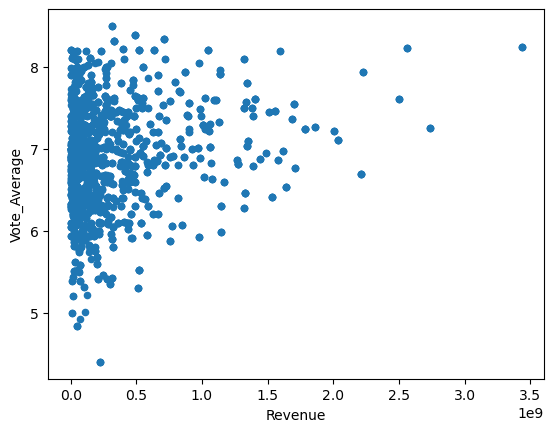

In [55]:
# Inspect the relationship between Vote_Average and Revenue
movies_exploded.plot(
    kind = 'scatter',
    x = 'Revenue',
    y = 'Vote_Average'
);

In [59]:
# We assume the average of our target variable, vote avg, is a linear function of the predictor variable, revenue 
lm_va_rev = smf.ols(
    'Vote_Average ~ Revenue', 
    data = movies_2015_2024
).fit()
lm_va_rev.params

Intercept    6.798164e+00
Revenue      2.913746e-10
dtype: float64

In [61]:
# generating predictions from our model using the predict method and feeding it the df
lm_va_rev.predict(movies_exploded)

0       7.340131
0       7.340131
0       7.340131
1       6.944264
1       6.944264
          ...   
1005    6.798254
1005    6.798254
1005    6.798254
1006    6.799043
1006    6.799043
Length: 2288, dtype: float64

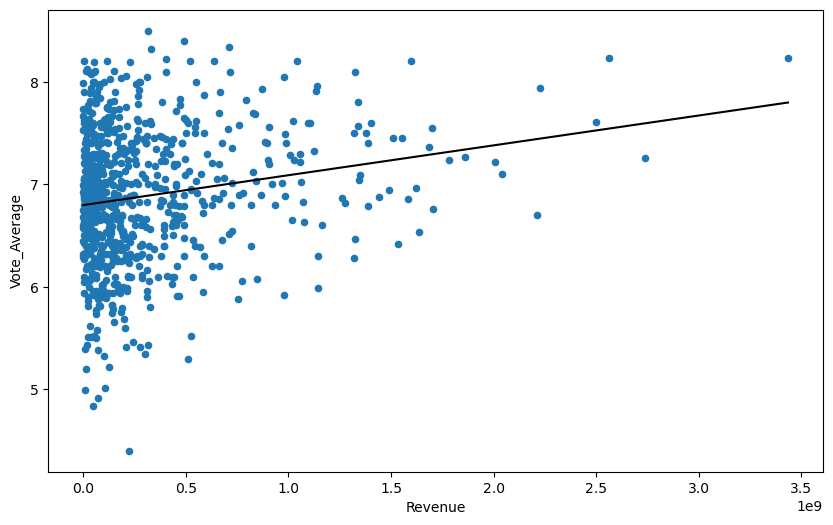

In [69]:
x_pred = pd.DataFrame({'Revenue': np.linspace(start = movies_2015_2024['Revenue'].min(),
                                             stop = movies_2015_2024['Revenue'].max(), 
                                             num = 250)
                      })

pred = lm_va_rev.predict(x_pred)

movies_2015_2024.plot(
    kind = 'scatter',
    x = 'Revenue',
    y = 'Vote_Average',
    figsize = (10,6)
)

plt.plot(x_pred['Revenue'], pred, color = 'black');

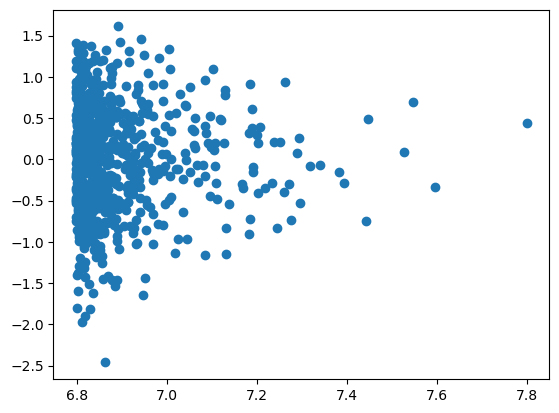

In [75]:
plt.scatter(x = lm_va_rev.fittedvalues, y = lm_va_rev.resid);

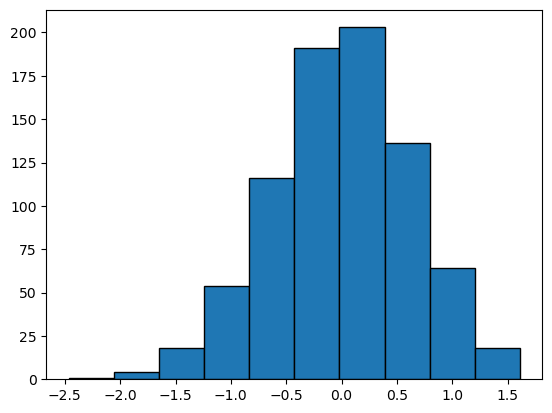

In [83]:
plt.hist(lm_va_rev.resid, edgecolor = 'black');

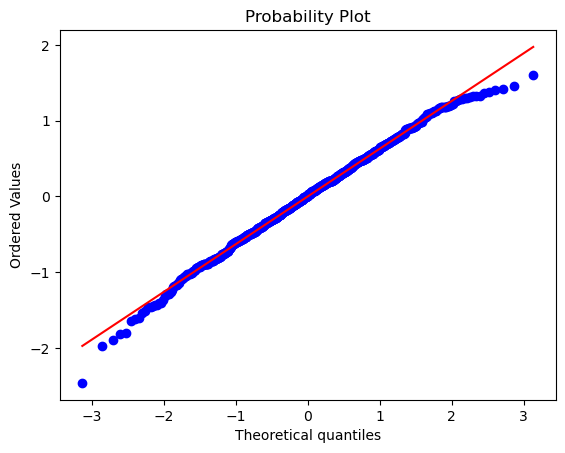

In [85]:
probplot(lm_va_rev.resid, plot = plt);

In [91]:
stats.stats.diagnostic.kstest_normal(lm_va_rev.resid)

(0.019012160167623526, 0.7080491194688886)

In [96]:
lm_va_rev.conf_int(alpha=0.05)

,0,1
Intercept,6.744630e+00,6.851698e+00
Revenue,1.838383e-10,3.989110e-10


In [98]:
lm_va_rev.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     28.29
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.36e-07
Time:                        00:34:48   Log-Likelihood:                -769.04
No. Observations:                 805   AIC:                             1542.
Df Residuals:                     803   BIC:                             1551.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7982      0.027    249.268      0.000       6.745       6.852
Revenue     2.914e-10   5.48e-11      5.319      0.000    1.84e-10    3.99e-10
==============================================================================
Omnibus:                        5.604   Durbin-Watson:                   0.068
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.508
Skew:                          -0.200   Prob(JB):                       0.0637
Kurtosis:                       3.062   Cond. No.                     6.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
x_pred = pd.DataFrame({'Revenue': np.linspace(start = movies_2015_2024['Revenue'].min(),
                                    stop = movies_2015_2024['Revenue'].max(), num = 250)})

lm_va_rev.get_prediction(x_pred).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6.798165,0.027272,6.744631,6.851698,5.560771,8.035559
1,6.802184,0.026840,6.749498,6.854870,5.564826,8.039542
2,6.806203,0.026423,6.754337,6.858070,5.568880,8.043526
3,6.810223,0.026021,6.759146,6.861300,5.572933,8.047513
4,6.814242,0.025634,6.763924,6.864561,5.576983,8.051501
...,...,...,...,...,...,...
245,7.782926,0.170757,7.447743,8.118109,6.502057,9.063795
246,7.786945,0.171506,7.450292,8.123599,6.505690,9.068200
247,7.790965,0.172256,7.452840,8.129089,6.509323,9.072607
248,7.794984,0.173005,7.455388,8.134580,6.512953,9.077015


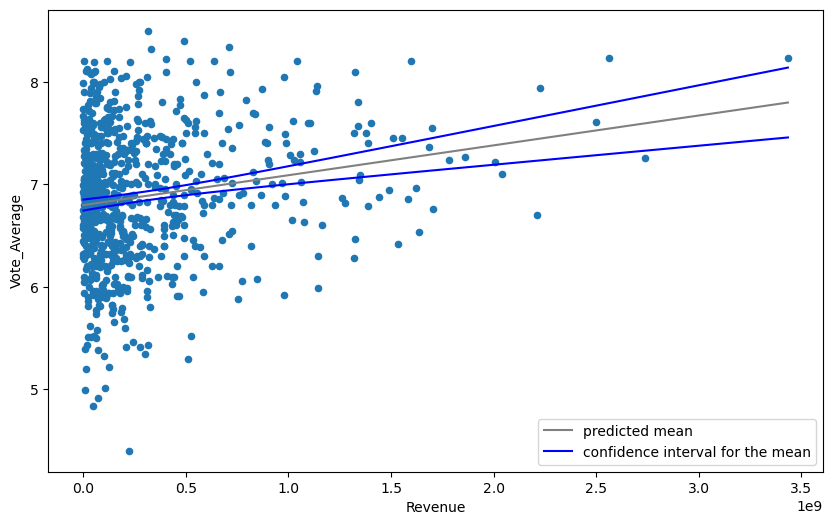

In [104]:
x_pred = pd.DataFrame({'Revenue': np.linspace(start = movies_2015_2024['Revenue'].min(),
                                    stop = movies_2015_2024['Revenue'].max(), num = 250)})

pred = lm_va_rev.get_prediction(x_pred).summary_frame()

movies_2015_2024.plot(
    kind = 'scatter',
    x = 'Revenue',
    y = 'Vote_Average',
    figsize = (10,6)
)

plt.plot(x_pred['Revenue'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Revenue'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval for the mean')
plt.plot(x_pred['Revenue'], pred['mean_ci_upper'], color = 'blue')

plt.legend();

In [111]:
x_pred = pd.DataFrame({'Revenue': np.linspace(start = movies_2015_2024['Revenue'].min(),
                                    stop = movies_2015_2024['Revenue'].max(), num = 250)})

lm_va_rev.get_prediction(x_pred).summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,6.798165,0.027272,6.744631,6.851698,5.560771,8.035559
1,6.802184,0.026840,6.749498,6.854870,5.564826,8.039542
2,6.806203,0.026423,6.754337,6.858070,5.568880,8.043526
3,6.810223,0.026021,6.759146,6.861300,5.572933,8.047513
4,6.814242,0.025634,6.763924,6.864561,5.576983,8.051501
...,...,...,...,...,...,...
245,7.782926,0.170757,7.447743,8.118109,6.502057,9.063795
246,7.786945,0.171506,7.450292,8.123599,6.505690,9.068200
247,7.790965,0.172256,7.452840,8.129089,6.509323,9.072607
248,7.794984,0.173005,7.455388,8.134580,6.512953,9.077015


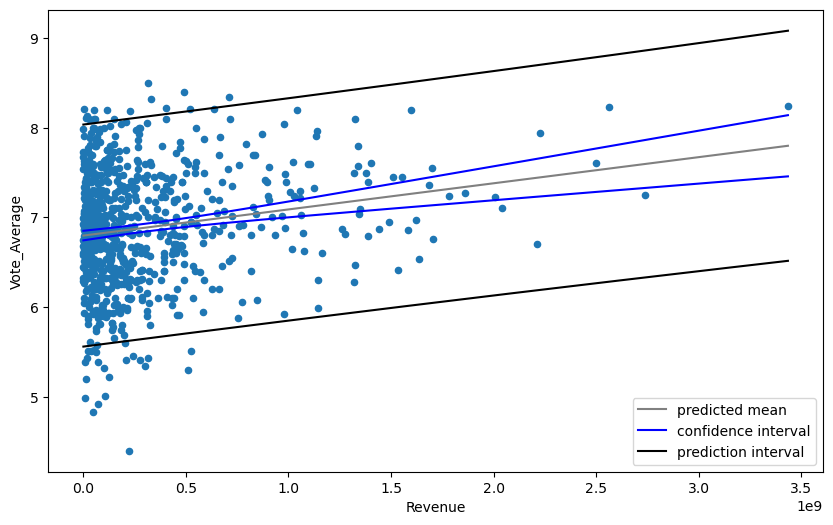

In [113]:
x_pred = pd.DataFrame({'Revenue': np.linspace(start = movies_2015_2024['Revenue'].min(),
                                    stop = movies_2015_2024['Revenue'].max(), num = 250)})

pred = lm_va_rev.get_prediction(x_pred).summary_frame()

movies_2015_2024.plot(
    kind = 'scatter',
    x = 'Revenue',
    y = 'Vote_Average',
    figsize = (10,6)
)

plt.plot(x_pred['Revenue'], pred['mean'], color = 'grey', label = 'predicted mean')

plt.plot(x_pred['Revenue'], pred['mean_ci_lower'], color = 'blue', label = 'confidence interval')
plt.plot(x_pred['Revenue'], pred['mean_ci_upper'], color = 'blue')

plt.plot(x_pred['Revenue'], pred['obs_ci_lower'], color = 'black', label = 'prediction interval')
plt.plot(x_pred['Revenue'], pred['obs_ci_upper'], color = 'black')

plt.legend();

In [ ]:

lm_va_rev.summary()

In [21]:
lm_vtavg_rev_exploded = smf.ols('Vote_Average ~ Profit', data = movies_exploded).fit()
lm_vtavg_rev_exploded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     131.7
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.10e-29
Time:                        00:20:38   Log-Likelihood:                -2155.7
No. Observations:                2288   AIC:                             4315.
Df Residuals:                    2286   BIC:                             4327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8012      0.015    448.455      0.000       6.771       6.831
Profit      4.835e-10   4.21e-11     11.477      0.000    4.01e-10    5.66e-10
==============================================================================
Omnibus:                        5.543   Durbin-Watson:                   0.670
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.551
Skew:                          -0.121   Prob(JB):                       0.0623
Kurtosis:                       2.993   Cond. No.                     4.20e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
lm_log_vtavg_rev_exploded = smf.ols('Vote_Average ~ I(np.log(Revenue+1))', data=movies_exploded).fit()
lm_log_vtavg_rev_exploded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Vote_Average   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     23.06
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.67e-06
Time:                        00:20:39   Log-Likelihood:                -2208.3
No. Observations:                2288   AIC:                             4421.
Df Residuals:                    2286   BIC:                             4432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  6.1987      0.145     42.806      0.000       5.915       6.483
I(np.log(Revenue + 1))     0.0371      0.008      4.802      0.000       0.022       0.052
==============================================================================
Omnibus:                       10.803   Durbin-Watson:                   0.637
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.863
Skew:                          -0.169   Prob(JB):                      0.00438
Kurtosis:                       3.009   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

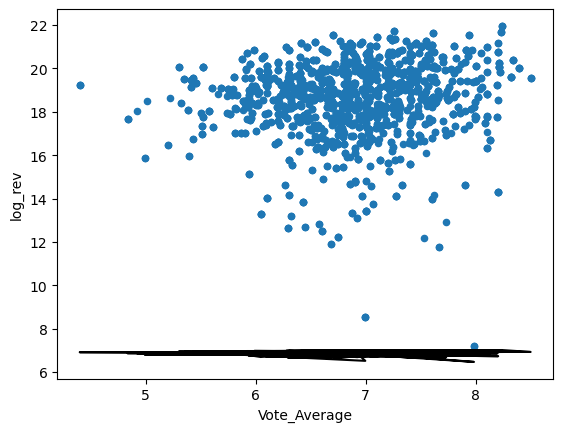

In [25]:
movies_exploded.plot(x = 'Vote_Average', y = 'log_rev', kind = 'scatter')
plt.plot(movies_exploded['Vote_Average'], lm_log_vtavg_rev_exploded.fittedvalues, color = 'black');

In [26]:
movies_exploded['Budget'].nsmallest(100)

377      43722
377      43722
873     102949
873     102949
755     267968
        ...   
132    5227997
132    5227997
132    5227997
133    5227997
167    5227997
Name: Budget, Length: 100, dtype: int64

In [29]:
#movies_exploded_nolow = movies_exploded[movies_exploded.Budget > 0]
#movies_exploded_nolow['Budget'].nsmallest(25)
#df = df[df.line_race != 0]
#movies_exploded['Budget'].nsmallest(2)

In [32]:
#lm_vtavg_rev_exploded = smf.ols('Revenue ~ Vote_Average', data = movies_exploded).fit()
#lm_vtavg_rev_exploded.summary()

In [34]:
#lm_vtavg_rev_exploded = smf.ols('np.log(Revenue) ~ Vote_Average', data = movies_exploded).fit()
#lm_vtavg_rev_exploded.summary()

In [36]:
movies_2015_2024.nsmallest(3, "Profit")

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit
727,The Gray Man,2022,"[Action, Thriller]",6.923,3989,214374604,486655,725201,-199545977
631,The Tomorrow War,2021,"[Action, Science Fiction, Adventure]",7.490,3871,231530427,16670190,588228,-185600000
848,The Killer,2023,"[Crime, Thriller]",6.579,2560,180161518,372793,800158,-174637887


In [38]:
lm_vtavg_profit_20152024 = smf.ols('np.log(Profit) ~ Vote_Average', data = movies_2015_2024).fit()
lm_vtavg_profit_20152024.summary()

C:\Users\cat\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(Profit)   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     16.19
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           6.39e-05
Time:                        00:20:40   Log-Likelihood:                -1215.8
No. Observations:                 665   AIC:                             2436.
Df Residuals:                     663   BIC:                             2445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       15.7413      0.630     25.000      0.000      14.505      16.978
Vote_Average     0.3650      0.091      4.024      0.000       0.187       0.543
==============================================================================
Omnibus:                       69.888   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.259
Skew:                          -0.749   Prob(JB):                     6.23e-23
Kurtosis:                       4.202   Cond. No.                         76.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
lm_vtavg_profit_2m_20152024 = smf.ols('np.log1p(Profit+200000000) ~ Vote_Average', data = movies_2015_2024).fit()
lm_vtavg_profit_2m_20152024.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log1p(Profit + 200000000)   R-squared:                       0.036
Model:                                      OLS   Adj. R-squared:                  0.035
Method:                           Least Squares   F-statistic:                     30.33
Date:                          Sun, 23 Nov 2025   Prob (F-statistic):           4.90e-08
Time:                                  00:20:40   Log-Likelihood:                -736.34
No. Observations:                           805   AIC:                             1477.
Df Residuals:                               803   BIC:                             1486.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       18.2658      0.230     79.350      0.000      17.814      18.718
Vote_Average     0.1834      0.033      5.507      0.000       0.118       0.249
==============================================================================
Omnibus:                      334.113   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10860.395
Skew:                          -1.222   Prob(JB):                         0.00
Kurtosis:                      20.827   Cond. No.                         76.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
#lm_vtavg_profit_20152024 = smf.ols('Profit ~ Vote_Average', data = movies_2015_2024).fit()
#lm_vtavg_profit_20152024.summary()

In [44]:
#I(np.log1p(rev_minue_budget)

In [46]:
movies_2015_2024['Fitted_Values'] = lm_vtavg_profit_2m_20152024.fittedvalues
movies_2015_2024 = movies_2015_2024.sort_values("Vote_Average")
movies_2015_2024.head(2)

,Title,Year,Genre,Vote_Average,Vote_Count,Budget,Revenue,TMDB_ID,Profit,Fitted_Values
38,Fantastic Four,2015,"[Action, Adventure, Science Fiction]",4.400,6264,158818481,222316222,166424,47977596,19.072863
899,Asterix & Obelix: The Middle Kingdom,2023,"[Family, Comedy, Adventure]",4.837,1119,74123596,47869098,643215,-25502322,19.153014


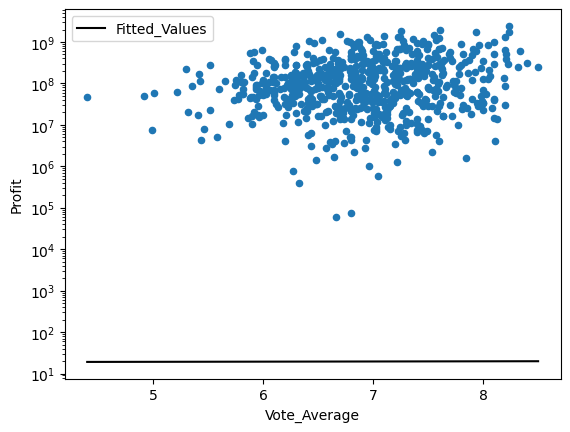

In [48]:
ax = movies_2015_2024.plot(
    x='Vote_Average',
    y='Profit',
    kind='scatter', 
    logy=True
)

movies_2015_2024.plot(
    ax=ax, x="Vote_Average", y="Fitted_Values", color='black'
);

#plt.annotate(text = 'P>|t|=0.000\nR-squared = 0.027', xy = (2e9, 6), fontsize = 12, xytext = (1.5e9, 6))
#plt.annotate(text = 'R-squared = 0.027', xy = (2e9, 6), fontsize = 12, xytext = (2e9, 6))
#, #arrowprops=dict(facecolor='black', shrink=0.1));